<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


In [1]:
%matplotlib inline

from __future__ import division, print_function

import itertools
import warnings
import pickle
import os

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from scipy.sparse import csr_matrix
from time import time

from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')
PATH_TO_DATA = '../data/capstone_user_identification/' 

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [3]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [4]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [82]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, test_size=0.3, 
                                                      random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [7]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [8]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1) 
score = cross_val_score(knn, X_train, y_train.astype('int'), cv=skf)
print(score)

[ 0.56925419  0.56968588  0.5552166 ]


**Запишите в файл *answer4_1.txt* доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [37]:
knn.fit(X_train, y_train.astype('int'))
pred = knn.predict(X_valid)

In [38]:
val_score = accuracy_score(y_valid.astype('int'), pred)
print(val_score)

0.584024650391


In [39]:
ans1 = [round(score.mean(), 3), round(val_score, 3)]

In [41]:
write_answer_to_file(' '.join(str(x) for x in ans1),'answer4_1.txt')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
y_train = y_train.astype('int')
y_valid = y_valid.astype('int')

In [46]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)
forest.fit(X_train, y_train)
oob_train = forest.oob_score_
print(oob_train)

0.722515748832


In [50]:
oop_test = forest.score(X_valid, y_valid)
print(oop_test)

0.735008295805


In [51]:
ans2 = [str(round(x, 3)) for x in [oob_train, oop_test]]
print(ans2)

['0.723', '0.735']


**Запишите в файл *answer4_2.txt* доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке на и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [52]:
write_answer_to_file(' '.join(ans2), 'answer4_2.txt')

In [54]:
!cat answer4_2.txt

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [55]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [56]:
logit = LogisticRegression(random_state=17)
score = cross_val_score(logit, X_train, y_train, cv=skf)
print(score)

[ 0.75616438  0.76974687  0.75716901]


In [58]:
logit.fit(X_train, y_train)
score_test = accuracy_score(y_valid, logit.predict(X_valid))
print(score_test)

0.781701825077


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [131]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class='multinomial', random_state=17, cv=skf, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 24.7 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [132]:
logit_mean_cv_scores1 = next (iter (logit_grid_searcher1.scores_.values())).mean(axis=0)
print(logit_mean_cv_scores1)

[ 0.31822225  0.47337913  0.55273512  0.65119285  0.71297117  0.75137565
  0.759199    0.75676288  0.74965153  0.74040474]


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [139]:
idx = np.where(logit_mean_cv_scores1==max(logit_mean_cv_scores1))[0][0]
print('C ', logit_grid_searcher1.Cs_[idx], ' : ', logit_mean_cv_scores1[idx])

C  1.0  :  0.759199001239


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

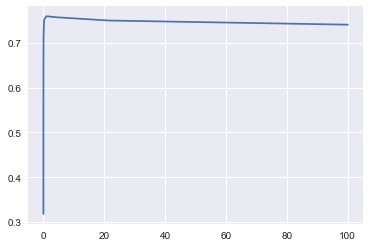

In [152]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(3, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [154]:
%%time
logit_c_values2 = np.linspace(3, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, multi_class='multinomial', random_state=17, cv=skf, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

20
Wall time: 1min 6s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [155]:
logit_mean_cv_scores2 = next(iter(logit_grid_searcher2.scores_.values())).mean(axis=0)
print(logit_mean_cv_scores2)

[ 0.75960708  0.75727033  0.75716991  0.7573728   0.75666169  0.75666178
  0.75615369  0.75584905  0.75554458  0.75584943  0.75554548  0.75503759
  0.75483484  0.75483505  0.75453067  0.75463254  0.75453089  0.7545307
  0.75392125  0.75381935]


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [156]:
idx = np.where(logit_mean_cv_scores2==max(logit_mean_cv_scores2))[0][0]
print('C ', logit_grid_searcher2.Cs_[idx], ' : ', logit_mean_cv_scores2[idx])

C  3.0  :  0.759607084457


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

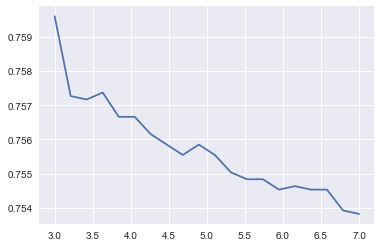

In [157]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [158]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
print(logit_cv_acc)

0.779094572174


In [159]:
ans3 = [str(round(x, 3)) for x in [max(logit_mean_cv_scores2), logit_cv_acc]]
print(ans3)

['0.76', '0.779']


**Запишите в файл *answer4_3.txt* доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [160]:
write_answer_to_file(' '.join(ans3), 'answer4_3.txt')

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [161]:
from sklearn.svm import LinearSVC

In [162]:
svm = LinearSVC(C=1, random_state=17)
score = cross_val_score(svm, X_train, y_train, cv=skf)
print(score)

[ 0.74672755  0.76059774  0.75106772]


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [163]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(estimator=svm, param_grid=svm_params1)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 1min 33s


[0.55771184718553135, 0.68451534241007927, 0.6834992887624467, 0.69223735013208698, 0.67770778297094092, 0.67882544198333672, 0.68685226579963421, 0.67567567567567566, 0.69213574476732376, 0.6827880512091038]


C:\Users\Public\PythonProjects\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


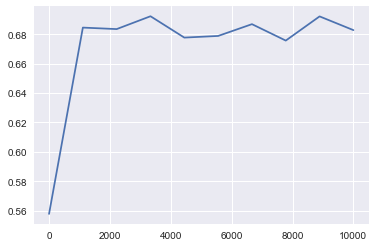

In [181]:
gd_scores = [x[1] for x in svm_grid_searcher1.grid_scores_]
print(gd_scores)
plt.plot(svm_params1['C'], gd_scores)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [183]:
idx = gd_scores.index(max(gd_scores))

print(svm_grid_searcher1.grid_scores_[idx][0]['C'], ' : ', max(gd_scores))

3333.3334  :  0.692237350132


C:\Users\Public\PythonProjects\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

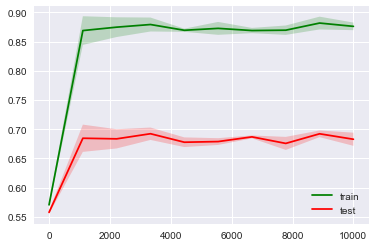

In [184]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [185]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 =  GridSearchCV(estimator=svm, param_grid=svm_params2)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 2min 32s


[0.66460069091648044, 0.75878886405202195, 0.76295468400731559, 0.76590123958545009, 0.76610445031497665, 0.76508839666734407, 0.76508839666734407, 0.76468197520829095, 0.76488518593781751, 0.76447876447876451, 0.76508839666734407, 0.76386913229018494, 0.76285307864255236, 0.76224344645397279, 0.76163381426539323, 0.76112578744157688, 0.7608209713472871, 0.76051615525299732, 0.75980491769965453, 0.75919528551107496, 0.75878886405202195, 0.75838244259296894, 0.75838244259296894, 0.7578744157691526, 0.75716317821580981, 0.7567567567567568, 0.75624872993294046, 0.7553342816500711, 0.75472464946149154, 0.75401341190814875]


C:\Users\Public\PythonProjects\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


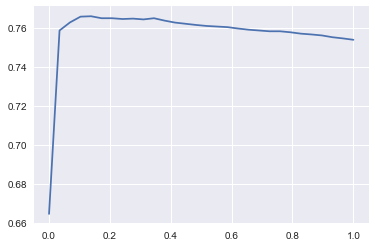

In [186]:
gd_scores = [x[1] for x in svm_grid_searcher2.grid_scores_]
print(gd_scores)
plt.plot(svm_params2['C'], gd_scores)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [187]:
idx = gd_scores.index(max(gd_scores))
print(svm_grid_searcher2.grid_scores_[idx][0]['C'], ' : ', max(gd_scores))

0.138793103448  :  0.766104450315


C:\Users\Public\PythonProjects\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

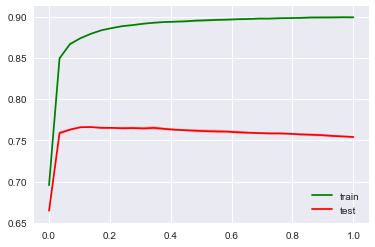

In [188]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [189]:
svm_cv_acc = accuracy_score(svm_grid_searcher2.best_estimator_.predict(X_valid), y_valid) 

In [191]:
ans4 = [str(round(x, 3)) for x in [svm_grid_searcher2.best_score_, svm_cv_acc]]

**Запишите в файл *answer4_4.txt* доли правильных ответов для svm_grid_searcher2 на кросс-валидации для лучшего значения параметра С и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [192]:
write_answer_to_file(' '.join(ans4), 'answer4_4.txt')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [204]:
import time

In [218]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    ''' ВАШ КОД ЗДЕСЬ '''
    
    time1 = time.time()
    
    with open(path_to_X_pickle, 'rb') as X_file:
        X_sparse_users = pickle.load(X_file)
        
    with open(path_to_y_pickle, 'rb') as y_file:
        y_users = pickle.load(y_file)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_users, y_users, test_size=test_size, 
                                                          random_state=random_state, stratify=y_users)
    y_train = np.array(y_train).astype('int')
    y_valid = np.array(y_valid).astype('int')
    
    scores = cross_val_score(estimator, X_train, y_train, cv=cv)
    
    estimator.fit(X_train, y_train)
    
    test_score = accuracy_score(estimator.predict(X_valid), y_valid)
    
    time2 = time.time()
    
    return[scores.mean(), test_score, time2 - time1]

**Убедитесь, что функция работает.**

In [205]:
model_assessment(svm_grid_searcher2.best_estimator_, os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

[ 0.7564688   0.7737115   0.75991458]
0.781701825077


[0.76336495901155565, 0.78170182507703245, 3.460456371307373]

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [201]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [220]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        print('lenght {}, window {} '.format(session_length, window_size))
        result = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf)
        print(result)
        print('-----------------------------------------------------------------------------------------------------')
        if window_size == 5 and session_length == 15:
            ans5 = result

lenght 15, window 10 
[0.82178965467061482, 0.84000948091964922, 6.854862928390503]
-----------------------------------------------------------------------------------------------------
lenght 10, window 10 
[0.76336495901155565, 0.78170182507703245, 3.5675315856933594]
-----------------------------------------------------------------------------------------------------
lenght 15, window 7 
[0.8470874683536852, 0.85448813671810186, 11.673342227935791]
-----------------------------------------------------------------------------------------------------
lenght 10, window 7 
[0.79758536954181647, 0.80753276920524308, 5.393826484680176]
-----------------------------------------------------------------------------------------------------
lenght 7, window 7 
[0.7544123057721982, 0.76290028206404514, 3.1462314128875732]
-----------------------------------------------------------------------------------------------------
lenght 15, window 5 
[0.86896707556748876, 0.87648174490279751, 14.012939

**Запишите в файл *answer4_5.txt* доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [222]:
ans5_t = [str(round(x, 3)) for x in ans5[:2]]
print(ans5_t)

['0.869', '0.876']


In [223]:
write_answer_to_file(' '.join(ans5_t), 'answer4_5.txt')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [224]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s{}_w{}.pkl'.format(session_length, window_size))
    print('lenght {}, window {} '.format(session_length, window_size))
    result = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf)
    print(result)
    print('-----------------------------------------------------------------------------------------------------')
    if window_size == 10 and session_length == 10:
        ans6 = result

lenght 5, window 5 
[0.40966616772947401, 0.42267727648805176, 618.1275053024292]
-----------------------------------------------------------------------------------------------------
lenght 7, window 7 
[0.43686797191901516, 0.45415062847021154, 592.3398807048798]
-----------------------------------------------------------------------------------------------------
lenght 10, window 10 
[0.46131133117144474, 0.48447915146207365, 564.5641815662384]
-----------------------------------------------------------------------------------------------------
Wall time: 29min 35s


**Запишите в файл *answer4_6.txt* доли правильных ответов для LinearSVC с настроенным параметром C и выборки *X_sparse_150users*. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [225]:
ans6_t = [str(round(x, 3)) for x in ans6[:2]]
print(ans6_t)

['0.461', '0.484']


In [226]:
write_answer_to_file(' '.join(ans6_t), 'answer4_6.txt')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [227]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [228]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [232]:
c = svm_grid_searcher2.best_params_['C']
print(c)

0.138793103448


In [233]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[c], multi_class='ovr', n_jobs=-1, random_state=17)
y_train_150 = y_train_150.astype('int')
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 5min 31s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [261]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))

User 1, CV score: 0.9953913188413451
User 2, CV score: 0.9959964216634555
User 3, CV score: 0.9948808876176063
User 4, CV score: 0.991210928449068
User 5, CV score: 0.9894589545285727
User 6, CV score: 0.9945784703554029
User 7, CV score: 0.9933377810517626
User 8, CV score: 0.98552845326941
User 9, CV score: 0.9977687120110285
User 10, CV score: 0.9944221069296252
User 11, CV score: 0.9941927773729834
User 12, CV score: 0.9933900984896172
User 13, CV score: 0.9969347498892217
User 14, CV score: 0.9949746477423452
User 15, CV score: 0.9963612828797493
User 16, CV score: 0.9962778894767852
User 17, CV score: 0.9903558768916115
User 18, CV score: 0.9942136042990658
User 19, CV score: 0.9947348013230198
User 20, CV score: 0.9908668432886172
User 21, CV score: 0.9787414185395896
User 22, CV score: 0.9965072897378852
User 23, CV score: 0.9936921205653299
User 24, CV score: 0.99013688596458
User 25, CV score: 0.9962882649305524
User 26, CV score: 0.994046747262726
User 27, CV score: 0.994839

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [292]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}
total = len(y_train_150)

for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = logit_cv_150users.scores_[user_id].mean() - (total - class_distr[user_id]) / total

In [293]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default

131

In [299]:
num_better_than_default = 121

In [300]:
ans7 = round(num_better_than_default / 150, 3)
print(ans7)

0.873


**Запишите в файл *answer4_7.txt* долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой. **

In [298]:
write_answer_to_file(ans7, 'answer4_7.txt')

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [273]:
y_binary_128 = [1 if u == 128 else 0 for u in y_150users]

In [274]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',facecolor=lines[0].get_color(), alpha=0.2)
        
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [276]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_train, y_train, n_jobs=-1, train_sizes=train_sizes)

Wall time: 16.5 s


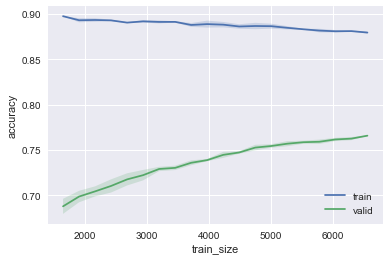

In [277]:
plot_learning_curve(val_train, val_test, n_train, xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
В этом проекте свобода творчества на каждом шаге, а 7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взимному оцениванию. Что еще можно добавить по 4 части проекта:
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/identify-me-if-you-can4) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/identify-me-if-you-can4) Kaggle Inclass.